# Checking the performance in a stratified KFold.

The preprocessing step uses the conclusions of the Exploratory script , and reproduces a part of it.

A (relatively simple) classical linear model and a bayesian linear model is trained on the 5 numerical features with the highest correlation with the target variable.

Stratified KFold (k=70) cross-validation is performed.

For each fold, all variables are normalized then both models are trained, and their Mean Absolute Errors on test set are stored. 

The price prediction of the bayesian linear model is performed by computing a sample from the posterior predictive distribution of the normalized log-price, then converting it to a distribution of prices, then taking the mean. Although the intermediate results show that the estimates of coefficients are similar for both models, the conversion to the prices (mean of exponents of the predictive distribution for the Bayesian model versus exponent of the mean for the linear model) creates a difference between predictions. 

----------------------------

Results. Despite the MAE are quite different across splits (SD equal 10000$), the error of the bayesian models tends to be smaller (mean difference between errors equals 120$). This slight improvement can be detected either at the level of the mean across folds, or at the level of differences between both errors for the same fold.

In [1]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns # for plotting the distributions of MAE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_absolute_error
from sklearn.preprocessing import StandardScaler # for scaling the features.

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import StratifiedKFold 

from scale_target import ScaleTarget
import bayesian_linear as blm
# the bayesian models.

In [2]:
# load data
file_path  = '../dat/train.csv'
data = pd.read_csv(file_path, index_col=0,  na_values='NA', keep_default_na=False)
del file_path

data.shape

(1460, 80)

# Function for converting the prices between different scales.

In [3]:
# def ScaleTarget(Y_train):
"""
    Normalize the log-norm-price variable, produce the function 
    for converting a prediction back to real prices.
    
    This function is analogous to 'StandardScaler',
    but is customized to the needs of the present task such as:

    include the exponent for converting log-prices to the scale of real prices; 
    be able to denormalize a Series or a DataFrame .

    Args:
        Y_train (Series): unnormalized log-prices.
    
    Returns: 
        norm_Y_train (Series): train set of normalized log-prices, 
        Sale_Price : inverse function 
            predictions of normalized log-prices ->
            predictions of real prices.
    """
    
    # mean_Y_train = Y_train.mean()
    # std_Y_train = Y_train.std(ddof=0)
    # norm_Y_train = (Y_train - mean_Y_train) / std_Y_train

    # define the inverse function
    # def Sale_Price(normalized_log):
"""
        The inverse to the normalization operations above .
        normalized LogSalePrice (the target variable in the models)
        -> SalePrice in dollars.

        'log-sale-price' is computed "manually" so that the function can be applied 
        either to a Series (in case of linear regression)
        or to a DataFrame  (in case of bayesian regression).

        Args:
            normalized_log (Series or DataFrame of floats): predicted normalized log-prices

        Returns:
            array of floats of the same size as input: the predicted prices.
    """

        # log_sale_price = normalized_log * std_Y_train + mean_Y_train
        # sale_Price = np.exp(log_sale_price) - 1
        # return sale_Price
    
    # return norm_Y_train, Sale_Price

'\n        The inverse to the normalization operations above .\n        normalized LogSalePrice (the target variable in the models)\n        -> SalePrice in dollars.\n\n        \'log-sale-price\' is computed "manually" so that the function can be applied \n        either to a Series (in case of linear regression)\n        or to a DataFrame  (in case of bayesian regression).\n\n        Args:\n            normalized_log (Series or DataFrame of floats): predicted normalized log-prices\n\n        Returns:\n            array of floats of the same size as input: the predicted prices.\n    '

# Preprocess variables.

1. Reset index  to ensure that the indices returned by 'StratifiedKFold' (from 0 to 1459) are correctly interpreted.

In [4]:
data.reset_index(inplace=True, drop=True)

2. Remove categorical features, those with many missing values or with high correlation with other ones.

In [5]:
# remove features with many missing values
features_with_na=data.isna().sum()[data.isna().sum()>0] / data.shape[0]  # ( this long line should be replaced by a 'def' )
list_to_drop=features_with_na[features_with_na > 0.1].index.tolist()
# drop the features with more than 10% of NA

list_to_drop
# ['LotFrontage', 'Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'] 

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [6]:
data.drop(list_to_drop, axis=1, inplace=True)
# remove these columns

print(data.shape)  # (1460, 74)

(1460, 74)


In [7]:
# feature selection
data = data.select_dtypes(include='number')

print(data.shape)
# (1460, 36)

(1460, 36)


In [8]:
# The features GarageCars , TotalBsmtSF should be removed because of high correlation with other ones.
# This is detected by the Exploratory Data Analysis.
data.drop(columns=['GarageCars', 'TotalBsmtSF'], inplace=True)

3. log(target variable)

In [9]:
data['LogSalePrice'] = np.log1p(data.SalePrice)  # inverse function: predicted_price = exp(y_pred) - 1 .
target = 'LogSalePrice'

# separate the original target variable to keep it available for interpreting the model predictions,
# but to avoid it being detected as column with high correlation with the new target.
data_Sale_price = data['SalePrice']  # for comparing the model predictions with the real prices
data.drop(columns='SalePrice', inplace=True)

print(data_Sale_price.shape)  # (1460,)
print(data_Sale_price.mean()) # 180921 $


(1460,)
180921.19589041095


In [10]:
# Keep the target and 5 most correlated numerical features for the model. 
k = 6

corrmat = data.corr()
cols = corrmat.nlargest(k, target).index.tolist()
# The names of features with highest correlation with log(SalePrice) .

"""
[
'LogSalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'FullBath',]
"""

cols
# As expected, the target variable 'LogSalePrice' is at the 1st position.

['LogSalePrice',
 'OverallQual',
 'GrLivArea',
 'GarageArea',
 '1stFlrSF',
 'FullBath']

In [11]:
# keep the 6 selected columns.
data = data[cols]
print(data.shape)  # (1460, 6)

n_samples = data.shape[0]  # The number of samples, used in KFold classifier below.



data.head()

(1460, 6)


,LogSalePrice,OverallQual,GrLivArea,GarageArea,1stFlrSF,FullBath
0,12.247699,7,1710,548,856,2
1,12.109016,6,1262,460,1262,2
2,12.317171,7,1786,608,920,2
3,11.849405,7,1717,642,961,1
4,12.429220,8,2198,836,1145,2


In [12]:
data.isnull().sum()
# Zeroes! The remaining columns have no missing values. 

LogSalePrice    0
OverallQual     0
GrLivArea       0
GarageArea      0
1stFlrSF        0
FullBath        0
dtype: int64

# Discretisation of prices.

In [13]:
price_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal')
#  default strategy : 'quantile'

y_discretized = price_discretizer.fit_transform(data[[target]])

print(type(price_discretizer))  # 'sklearn.preprocessing._discretization.KBinsDiscretizer'
print(price_discretizer.bin_edges_)
# [array([10.46027076, 11.57567464, 11.72804491, 11.8167343 , 11.89819467,
#         12.00151161, 12.09670954, 12.19915334, 12.34583894, 12.53537999,
#         13.53447435]) 

print(y_discretized.shape)  # (1460, 1) 

# append y_discretized to the Dataframe.
data['discr_price'] = y_discretized

# Take a look at the data with the discretizer
print(data.shape)  # (1460, 7)
data.head()

<class 'sklearn.preprocessing._discretization.KBinsDiscretizer'>
[array([10.46027076, 11.57567464, 11.72804491, 11.8167343 , 11.89819467,
        12.00151161, 12.09670954, 12.19915334, 12.34583894, 12.53537999,
        13.53447435])                                                   ]
(1460, 1)
(1460, 7)


,LogSalePrice,OverallQual,GrLivArea,GarageArea,1stFlrSF,FullBath,discr_price
0,12.247699,7,1710,548,856,2,7.0
1,12.109016,6,1262,460,1262,2,6.0
2,12.317171,7,1786,608,920,2,7.0
3,11.849405,7,1717,642,961,1,3.0
4,12.429220,8,2198,836,1145,2,8.0


<Axes: >

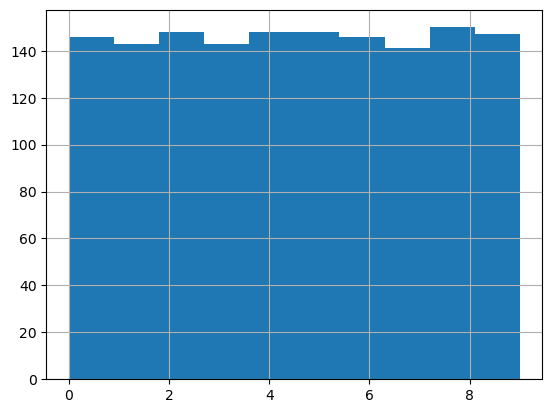

In [14]:
data['discr_price'].hist()
# The histogram is uniform, which is normal for the quantile strategy.
# Each bin contains more than 140 samples, which is enough for a stratified split.

# Stratified KFold.

In [15]:
# lists for storing the results
lst_mae_lin_reg_train = []
lst_mae_lin_reg_test = []
lst_mae_lin_reg_train_bayes  = []
lst_mae_lin_reg_test_bayes  = []


skf = StratifiedKFold(n_splits=70)
# Quite a high value, which leads to test sets of 2 or 3 points in each level of discretized price.

In [16]:
%%time
# main loop : Stratified K-Fold 

# Recall: n_samples = 1460
for fold, (train_ind, test_ind) in enumerate(skf.split(np.zeros(n_samples) , data['discr_price'])):
    print("Fold:", fold)
    
    X_train = data.loc[train_ind, cols[1:]]
    X_test = data.loc[test_ind, cols[1:]]
    Y_train = data.loc[train_ind, target]
    sale_price_train = data_Sale_price.loc[train_ind]  
    sale_price_test = data_Sale_price.iloc[test_ind]
        
    # scale the features
    X_scal = StandardScaler()
    norm_train_features = X_scal.fit_transform(X_train)
    norm_test_features = X_scal.transform(X_test)

    # scale the target.
    norm_Y_train, Sale_Price = ScaleTarget(Y_train)
    
    def posterior_predictive_mae(sale_price, df_posterior_pred):
        """
        Predicts prices in initial scale using each column as a sample
        from posterior predictive distribution of normed log-price.
        The prediction rule is: convert the distribution to a distribution of real prices
        (denormalization, followed by exponent),
        then take its mean.

        Args:
        sale_price (Series): the ground truth about prices of transactions.    
        df_posterior_pred (DataFrame with one column per row of the initial distribution):
            the posterior predictive distributions of normed log-price ;

        Returns: the MAE of Bayesian prediction (float).
        """
    
        pred_price_bayes = Sale_Price(df_posterior_pred).mean()
        return mean_absolute_error(sale_price, pred_price_bayes)
    
    # Define the model of multiple linear regression.
    reg = LinearRegression().fit(norm_train_features, norm_Y_train)

    # Performance on train, test sets (in terms of price).
    pred_norm_log_train = reg.predict(norm_train_features)
    pred_price_train = Sale_Price(pred_norm_log_train) 
    lst_mae_lin_reg_train.append(np.round(mean_absolute_error(sale_price_train, pred_price_train)))

    pred_norm_log_test = reg.predict(norm_test_features)
    pred_price_test = Sale_Price(pred_norm_log_test)
    lst_mae_lin_reg_test.append(np.round(mean_absolute_error(sale_price_test, pred_price_test)))

    # Define the model of bayesian linear regression.
    df_posterior_pred_train, df_posterior_pred_test = blm.fit_predict(
            norm_train_features, norm_test_features, observed=norm_Y_train.to_frame())

    lst_mae_lin_reg_train_bayes.append(np.round(posterior_predictive_mae(sale_price_train, df_posterior_pred_train)))
    lst_mae_lin_reg_test_bayes.append(np.round(posterior_predictive_mae(sale_price_test, df_posterior_pred_test)))
    

Fold: 0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 1


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 2


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 3


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 4


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 5


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 6


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 7


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 9


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 10


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 11


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 12


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 13


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 14


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 15


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 16


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 17


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 18


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 19


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 20


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 21


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 22


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 23


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 24


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 25


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 26


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 27


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 28


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 29


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 30


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 31


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 32


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 33


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 34


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 35


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 36


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 37


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 38


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 39


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 40


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 41


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 42


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 43


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 44


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 45


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 46


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 47


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 48


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 49


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 50


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 51


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 52


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 53


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 54


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 55


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 56


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 57


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 58


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 59


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 60


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 61


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 62


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 63


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 64


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 65


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 66


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 67


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 68


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


Fold: 69


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [y]


CPU times: user 5min 14s, sys: 30.5 s, total: 5min 45s
Wall time: 8min 2s


In [17]:
def lst_to_summary_stat(lst: list, name_series: str):
    arr_lst = np.array(lst)
    summary_str = "MAE of " + name_series + ": " + str(lst) + ", mean = " + str(arr_lst.mean()) + ", SD = " + str(arr_lst.std())
    return summary_str

In [18]:
# convert to arrays

arr_mae_lin_reg_test = np.array(lst_mae_lin_reg_test)
arr_mae_lin_reg_test_bayes = np.array(lst_mae_lin_reg_test_bayes)

In [19]:
# Print the results with summary statistics
# v2:
"""
print(lst_to_summary_stat(lst_mae_lin_reg_train, "lin-reg (train sets)"))
print(lst_to_summary_stat(lst_mae_lin_reg_test, "lin-reg (test sets)"))  # mean = 23749.8, SD = 1363.4
print(lst_to_summary_stat(lst_mae_lin_reg_train_bayes, "bayesian lin-reg (train sets)"))
print(lst_to_summary_stat(lst_mae_lin_reg_test_bayes, "bayesian lin-reg (test sets)"))  # mean = 23657.6, SD = 1385.8
"""
# The MAE on test sets are quite similar, but a bit smaller for bayesian models!

print("The mean MAE of linear regression model is:", arr_mae_lin_reg_test.mean()) # 23764 $
print("The mean MAE of bayesian linear regression model is:", arr_mae_lin_reg_test_bayes.mean())  # 23645 $
print("----------")
print("The Standard Deviation of MAE of linear regression model is:", arr_mae_lin_reg_test.std())
print("The Standard Deviation of MAE of bayesian linear regression model is:", arr_mae_lin_reg_test_bayes.std())
# 10000 $

The mean MAE of linear regression model is: 23763.757142857143
The mean MAE of bayesian linear regression model is: 23645.185714285715
----------
The Standard Deviation of MAE of linear regression model is: 9899.914555815569
The Standard Deviation of MAE of bayesian linear regression model is: 9975.909206387238


Text(0.5, 0, 'MAE of linear model ($)')

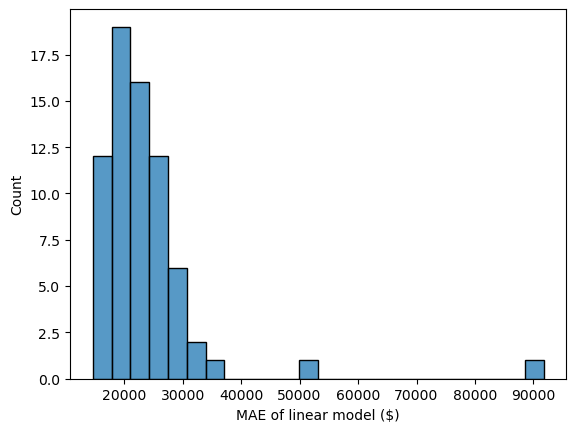

In [20]:
# display the distributions of Mean Absolute Errors  
def plot_series(in_series):
    __, ax = plt.subplots()
    sns.histplot(in_series, ax=ax)
    return ax

ax_mae_linear = plot_series(arr_mae_lin_reg_test)
ax_mae_linear.set_xlabel("MAE of linear model ($)")

Text(0.5, 0, 'MAE of bayesian linear model ($)')

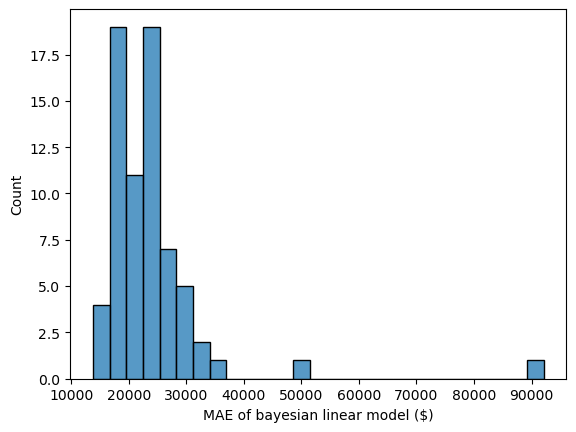

In [21]:
ax_mae_bayesian = plot_series(arr_mae_lin_reg_test_bayes)
ax_mae_bayesian.set_xlabel("MAE of bayesian linear model ($)")

Text(0.5, 0, 'Differences of MAE between models')

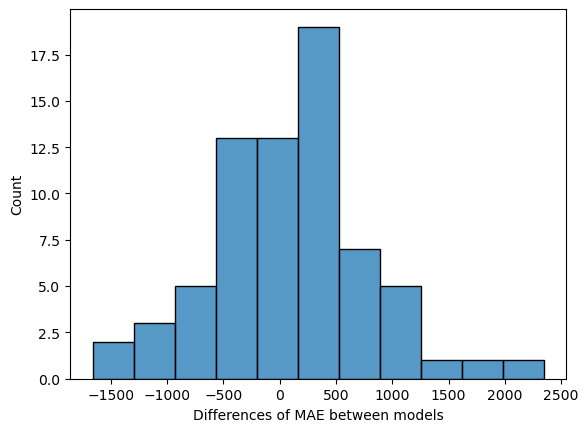

In [22]:
# Plot the differences of MAE on each fold. 

ax_diff_mae = plot_series(arr_mae_lin_reg_test - arr_mae_lin_reg_test_bayes)
ax_diff_mae.set_xlabel("Differences of MAE between models")
# The distribution tends to be centered on positive values of difference.

Conclusion.

The bayesian linear model on the same features performs slightly better. The difference between means equals 120$, which is quite small in comparison with the variation as function of fold (Standard Deviation equals 10000 $). The distributions of MAE of both models confirm this conclusion as they are quite similar.

The histogram of differences shows the MAE for each split are relatively close, and that the bayesian model tends to perform consistently slightly better.